In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib as plt
from itertools import chain
import ast

In [2]:
df = pd.read_csv("full_set.csv")
df.shape

(588793, 31)

In [3]:
TARGET_CLASS = "CHM2210"

# converts strings to arrays
df['Classes'] = df['Classes'].apply(ast.literal_eval)
df['Semester Grades'] = df['Semester Grades'].apply(ast.literal_eval)
df['Semester Points'] = df['Semester Points'].apply(ast.literal_eval)
df['CRN'] = df['CRN'].apply(ast.literal_eval)

# find all people who took class
Pidms_with_TARGET_CLASS = df[df['Classes'].apply(lambda x: TARGET_CLASS in x)]['Pidm'].unique()
df = df[df['Pidm'].isin(Pidms_with_TARGET_CLASS)]
df = df[['Pidm', 'Semester', 'HS GPA', 'Converted_SAT', 'Semester Points', 'Semester Grades', 'CRN', 'Classes']]
df.head(4)

# Find the first semester with TARGET_CLASS for each student
def find_first_semester(student_df):
    chm2210_row = student_df[student_df['Classes'].apply(lambda x: TARGET_CLASS in x)]
    if not chm2210_row.empty:
        return chm2210_row['Semester'].min()
    return None

first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename('Target_Semester')
df = df.merge(first_semester, on='Pidm')

# filter all semesters after student took TARGET_CLASS
filtered_df = df[df['Semester'] <= df['Target_Semester']]

# find grades/points for TARGET_CLASS and output it to a new column
def find_class_grades(student_df):
    for _, row in student_df.iterrows():
        if TARGET_CLASS in row['Classes']:
            index = row['Classes'].index(TARGET_CLASS)
            return row['Semester Points'][index], row['Semester Grades'][index]
    return None, None

class_grades = filtered_df.groupby('Pidm').apply(lambda x: find_class_grades(x)).apply(pd.Series)
class_grades.columns = ['Target_Points', 'Target_Grade']

final_df = filtered_df.merge(class_grades, on='Pidm')

# filter out these grades
final_df = final_df[~final_df['Target_Grade'].isin(['WE', 'IF', 'W', 'WC'])]

display(df[df['Pidm'] ==  134328])
final_df = final_df[final_df['Semester'] < final_df['Target_Semester']]
display(final_df[final_df['Pidm'] ==  134328])
groupped_df = final_df.groupby('Pidm').agg({
    "HS GPA": 'first',
    'Converted_SAT': 'first',
    'Semester Grades': lambda x: sum(x, []),
    'Semester Points': lambda x: sum(x, []),
    'Classes': lambda x: sum(x, []),
    'CRN': lambda x: sum(x, []),
    'Target_Grade': 'first',
    'Target_Points': 'first',
}).reset_index()

all_classes = sorted(set(chain.from_iterable(groupped_df['Classes'])))

def create_one_hot(classes, points, all_classes):
    one_hot_vector = [-1] * len(all_classes)
    for class_name, point in zip(classes, points):
        if class_name in all_classes:
            one_hot_vector[all_classes.index(class_name)] = point
    return one_hot_vector

groupped_df['One_Hot_Classes'] = groupped_df.apply(
    lambda row: create_one_hot(row['Classes'], row['Semester Points'], all_classes), axis=1
)

one_hot_df = pd.DataFrame(groupped_df['One_Hot_Classes'].tolist(), columns=all_classes, index=groupped_df['Pidm'])

from sklearn.model_selection import train_test_split

train, testing_data = train_test_split(one_hot_df, test_size=0.2, random_state=50)
dev, test = train_test_split(testing_data, test_size=0.5, random_state=50)

train_set = one_hot_df[one_hot_df.index.isin(train.index)]
dev_set = one_hot_df[one_hot_df.index.isin(dev.index)]
test_set = one_hot_df[one_hot_df.index.isin(test.index)]
columns_to_remove = []
for column in train_set.columns:
    value_counts = train_set[column].value_counts()
    max_count = value_counts.max()
    non_max_count = value_counts.sum() - max_count
    
    if non_max_count <= 0:
        columns_to_remove.append(column)
        
train_set = train_set.drop(columns=columns_to_remove)
dev_set = dev_set.drop(columns=columns_to_remove)
test_set = test_set.drop(columns=columns_to_remove)

print(train_set.shape, dev_set.shape, test_set.shape)

C:\Users\judem\AppData\Local\Temp\ipykernel_21232\2545726050.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename('Target_Semester')
C:\Users\judem\AppData\Local\Temp\ipykernel_21232\2545726050.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_grades = filtered_df.groupby('Pidm').apply(lambda x: find_class_grades(x))

,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes,Target_Semester
0,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]",201708
1,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101],201708
2,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]",201708
3,134328,201708,3.0,1370.0,"[1.0, 1.33, 0.0, 2.33]","[D, D+, F, C+]","[86672.0, 87939.0, 88312.0, 91803.0]","[CHM2210, PCB3063, CHM2210L, EGS3720]",201708
4,134328,201808,3.0,1370.0,"[4.0, 0.0]","[A, S]","[80885.0, 89183.0]","[COP2510, EGN3000]",201708
5,134328,201901,3.0,1370.0,"[1.0, 0.0, 0.0]","[D, F, F]","[17655.0, 18741.0, 19361.0]","[COP3514, COT3100, CDA3103]",201708


,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes,Target_Semester,Target_Points,Target_Grade
0,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]",201708,1.0,D
1,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101],201708,1.0,D
2,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]",201708,1.0,D


(9424, 1433) (1178, 1433) (1179, 1433)


In [4]:
groupped_df

,Pidm,HS GPA,Converted_SAT,Semester Grades,Semester Points,Classes,CRN,Target_Grade,Target_Points,One_Hot_Classes
0,134328,3.00,1370.0,"[C, B, A, B, A-]","[2.0, 3.0, 4.0, 3.0, 3.67]","[BSC2010L, BSC2010, ENC1101, PSY2012, ARC2211]","[11143.0, 23005.0, 11691.0, 52696.0, 52892.0]",D,1.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,706382,3.44,1280.0,"[A, A+, A, WC, WC, WC, WC, A, A]","[4.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0]","[AMH2020, CHM2045, CHM2045L, CHM2046, CHM2046L...","[80953.0, 82346.0, 84033.0, 15234.0, 15241.0, ...",A,4.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,1085786,2.50,1180.0,"[B, A, B, B+, A, W, W, B-, A, B, D, A, B-, A, ...","[3.0, 4.0, 3.0, 3.33, 4.0, 0.0, 0.0, 2.67, 4.0...","[MAC2311, ECO2013, BSC2010, AMS4804, BSC2010L,...","[80534.0, 81300.0, 83081.0, 87275.0, 94320.0, ...",A-,3.67,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,1096567,3.85,1340.0,"[A-, A-, B-, W, A+, D, B, A+, B+, B, A, A+, A-...","[3.67, 3.67, 2.67, 0.0, 4.0, 1.0, 3.0, 4.0, 3....","[MAC1147, ENC1102, CHM2045, CHM2045L, SLS2901,...","[82970.0, 89553.0, 92762.0, 92839.0, 93253.0, ...",C,2.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,1302110,2.43,1040.0,[A],[4.0],[PCB3063],[54321.0],A+,4.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...
11776,3873128,3.88,1190.0,"[B+, B, A, B, A+, A]","[3.33, 3.0, 4.0, 3.0, 4.0, 4.0]","[PSY3213, BSC2010, BSC2010L, CHM2046, MHS3063,...","[80378.0, 81087.0, 81825.0, 82555.0, 83207.0, ...",B+,3.33,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
11777,3877042,4.08,1180.0,"[B, A+, A, A, B, W, A+, A, A, D]","[3.0, 4.0, 4.0, 4.0, 3.0, 0.0, 4.0, 4.0, 4.0, ...","[HSC4537, CHM2046, BSC2086, BSC2086L, PCB3023L...","[82097.0, 82555.0, 83986.0, 83987.0, 10655.0, ...",B+,3.33,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
11778,3878121,3.65,1370.0,"[A, A, A+]","[4.0, 4.0, 4.0]","[HSC4537, HSC4631, ENC1102]","[82097.0, 82314.0, 88675.0]",A-,3.67,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
11779,3879752,3.92,1340.0,"[B+, B-, C+]","[3.33, 2.67, 2.33]","[PCB3063, BSC3312, MAC2241]","[81419.0, 85547.0, 86259.0]",C+,2.33,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [5]:
# Create pass/fail column
def map_pass_fail(grade):
    fail_grades = ['F', 'IF', 'W', 'D-', 'F', 'D+', 'D#', 'D+', 'F#', 'D', 'D', 'D-', 'U', 'W', 'F*', 'D*', 'CF', 'I', 'FF', 'Z', 'W*', 'F+', 'F-', 'F#', 'F*', 'D-*', 'IF', 'IF*', 'D+*', 'CIF', 'Z*', 'IU', 'M', 'CI', 'MU', 'U*', 'ID', 'IB', 'IU*', 'IS', 'CW']
    return 0 if grade in fail_grades else 1  # 0 = fail, 1 = pass

#Add columns fro grouped_df
groupped_df_filtered = groupped_df[groupped_df['Pidm'].isin(train_set.index)]
add_columns = ['HS GPA', 'Converted_SAT', 'Target_Grade']
groupped_df_filtered.set_index('Pidm', inplace=True)
train_set = train_set.join(groupped_df_filtered[add_columns], )

groupped_df_filtered = groupped_df[groupped_df['Pidm'].isin(dev_set.index)]
add_columns = ['HS GPA', 'Converted_SAT', 'Target_Grade']
groupped_df_filtered.set_index('Pidm', inplace=True)
dev_set = dev_set.join(groupped_df_filtered[add_columns], )

# Apply the function to create pass/fail column
train_set['pass_fail'] = train_set['Target_Grade'].apply(map_pass_fail)
dev_set['pass_fail'] = dev_set['Target_Grade'].apply(map_pass_fail)

# # Drop irrelevant columns
X = train_set.drop(columns=['Target_Grade', 'pass_fail'])
X_dev = dev_set.drop(columns=['Target_Grade', 'pass_fail'])

# Convert all remaining object columns to numeric
# X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
X = X.dropna()
X_dev = X_dev.dropna()

# Extract the target variable (pass/fail)
y = train_set.loc[X.index, 'pass_fail']
y_dev = dev_set.loc[X_dev.index, 'pass_fail']

In [6]:
counts = train_set['pass_fail'].value_counts()
counts.get(1, 1)
print(counts.get(0, 0))
print(counts.get(1, 1))

1122
8302


In [7]:
train_set

ACG2021  ACG2071  ACG3074  ACG3103  ACG3341  ADV2214  ADV3008  \
Pidm                                                                     
706382      -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1096567     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1344811     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1345984     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1348806     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3872463     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3877042     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3878121     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3879752     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3883568     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFA2000  AFA2380  AFA3110  AFA4150  AFA4335  AFA4430  AFA4931  \
Pidm                                                                     
706382      -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1096567     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1344811     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1345984     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1348806     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3872463     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3877042     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3878121     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3879752     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3883568     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFH3100  AFH3200  AFR1101  AFR1120  AFR2001  AFR2130  AFR2140  \
Pidm                                                                     
706382      -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1096567     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1344811     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1345984     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1348806     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3872463     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3877042     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3878121     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3879752     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3883568     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFR3220  AFR3231  AFR4201  AFS2250  AMH2010  AMH2020  AMH3140  \
Pidm                                                                     
706382      -1.0     -1.0     -1.0     -1.0     -1.0      4.0     -1.0   
1096567     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1344811     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1345984     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
1348806     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3872463     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3877042     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3878121     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3879752     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3883568     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AMH3160  AMH3170  AMH3270  AMH3403  AMH3421  AMH3423  AMH3533  \
Pidm                                                                     
706382   

In [8]:
from sklearn.utils import resample
# Apply undersampling to balance the classes
# Separate the pass and fail instances
pfcounts = train_set['pass_fail'].value_counts()
sample_count = min(counts.get(0, 0), counts.get(1, 1))

pass_class = X[y == 1]
fail_class = X[y == 0]

pass_sample = resample(pass_class, replace=False, n_samples=sample_count, random_state=50)
fail_sample = resample(fail_class, replace=False, n_samples=sample_count, random_state=50)

# Combine the undersampled data
X_undersampled = pd.concat([pass_sample, fail_sample])
y_undersampled = pd.concat([y[pass_sample.index], y[fail_sample.index]])

In [9]:
print(counts.get(0, 0))
print(counts.get(1, 1))
print(sample_count)
display(pass_sample)
display(fail_sample)

1122
8302
1122


ACG2021  ACG2071  ACG3074  ACG3103  ACG3341  ADV2214  ADV3008  \
Pidm                                                                     
3570131     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3103513     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3102668     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3400610     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3349080     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3521853     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3632792     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3600128     -1.0     -1.0      4.0     -1.0     -1.0     -1.0     -1.0   
3350916     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3401151     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFA2000  AFA2380  AFA3110  AFA4150  AFA4335  AFA4430  AFA4931  \
Pidm                                                                     
3570131     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3103513     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3102668     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3400610     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3349080     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3521853     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3632792     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3600128     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3350916     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3401151     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFH3100  AFH3200  AFR1101  AFR1120  AFR2001  AFR2130  AFR2140  \
Pidm                                                                     
3570131     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3103513     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3102668     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3400610     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3349080     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3521853     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3632792     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3600128     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3350916     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3401151     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFR3220  AFR3231  AFR4201  AFS2250  AMH2010  AMH2020  AMH3140  \
Pidm                                                                     
3570131     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3103513     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3102668     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3400610     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3349080     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3521853     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3632792     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3600128     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3350916     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3401151     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AMH3160  AMH3170  AMH3270  AMH3403  AMH3421  AMH3423  AMH3533  \
Pidm                                                                     
3570131  

ACG2021  ACG2071  ACG3074  ACG3103  ACG3341  ADV2214  ADV3008  \
Pidm                                                                     
3506043     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3411183     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3084566     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3698977     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3648088     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3811875     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3191914     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3072611     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3124988     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3109120     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFA2000  AFA2380  AFA3110  AFA4150  AFA4335  AFA4430  AFA4931  \
Pidm                                                                     
3506043     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3411183     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3084566     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3698977     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3648088     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3811875     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3191914     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3072611     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3124988     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3109120     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFH3100  AFH3200  AFR1101  AFR1120  AFR2001  AFR2130  AFR2140  \
Pidm                                                                     
3506043     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3411183     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3084566     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3698977     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3648088     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3811875     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3191914     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3072611     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3124988     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3109120     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AFR3220  AFR3231  AFR4201  AFS2250  AMH2010  AMH2020  AMH3140  \
Pidm                                                                     
3506043     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3411183     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3084566     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3698977     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3648088     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
...          ...      ...      ...      ...      ...      ...      ...   
3811875     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3191914     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3072611     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3124988     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   
3109120     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0     -1.0   

         AMH3160  AMH3170  AMH3270  AMH3403  AMH3421  AMH3423  AMH3533  \
Pidm                                                                     
3506043  

In [22]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
# X_train = X_undersampled
# y_train = y_undersampled
X_train = X
y_train = y
X_test = X_dev
y_test = y_dev
# X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=50)

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', seed=42)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],  # Try different learning rates
    'max_depth': [3, 6, 9],             # Try different tree depths
    'n_estimators': [100, 300, 500],     # Number of boosting rounds
    'subsample': [0.8, 1.0],            # Subsample ratio
    'colsample_bytree': [0.8, 1.0]      # Column sampling
}

# Initialize GridSearchCV with the XGBoost classifier
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train the final model using the best parameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Label Model
print("############ XGBoost Classifier ############")

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")



Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
Best Cross-Validation Accuracy: 0.88
############ Gradient Boost Classifier ############
Accuracy: 0.87
Confusion Matrix:
[[   8  144]
 [   5 1021]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.05      0.10       152
           1       0.88      1.00      0.93      1026

    accuracy                           0.87      1178
   macro avg       0.75      0.52      0.51      1178
weighted avg       0.84      0.87      0.82      1178



Feature Importances (sorted):
       Feature  Importance
0      CHM2046    0.080650
1      ENG4674    0.012751
2      WST2600    0.012592
3      PCB3063    0.012129
4     BSC2010L    0.011839
...        ...         ...
1430  ZOO4307L    0.000000
1431   ZOO4454    0.000000
1432   ZOO4512    0.000000
1433   ZOO4513    0.000000
1434   ZOO4694    0.000000

[1435 rows x 2 columns]


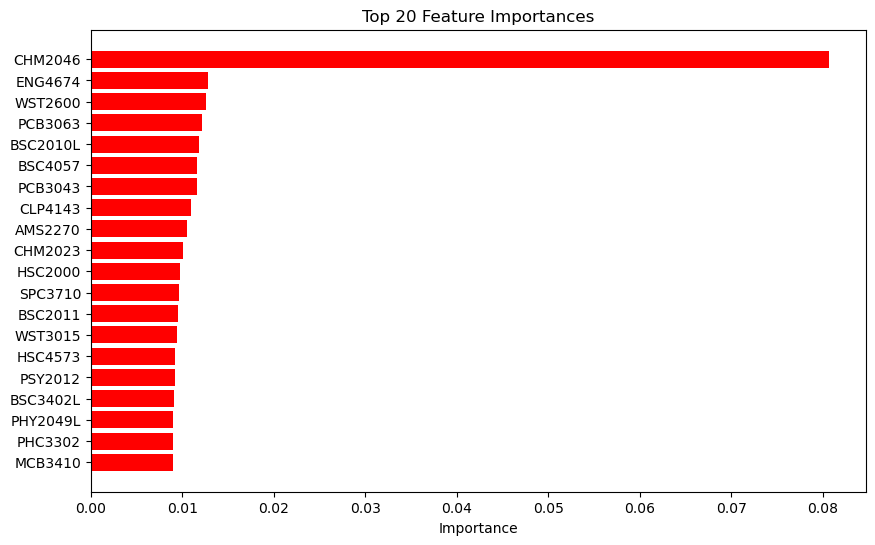

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the feature importances from the AdaBoost classifier
feature_importances = best_model.feature_importances_

# Get the column names (features)
feature_names = X.columns

# Pair the feature names with their corresponding importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Convert to a DataFrame for easy display and access
feature_importance_df = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

# Display the feature importances as a DataFrame
print("Feature Importances (sorted):")
print(feature_importance_df)

# Plotting the top 20 features for visualization
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
top_features = feature_importance_df.head(20)  # Plot the top 20 features
plt.barh(top_features['Feature'], top_features['Importance'], color='r')
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # To display the highest at the top
plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# X_train = X_undersampled
# y_train = y_undersampled
X_train = X
y_train = y
X_test = X_dev
y_test = y_dev
# X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=50)

model = GradientBoostingClassifier()
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'n_estimators': [100, 200, 300],    # Number of boosting stages
    'max_depth': [3, 5, 7]              # Maximum depth of individual trees
}

# Initialize GridSearchCV with the XGBoost classifier
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train the final model using the best parameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Label Model
print("############ Gradient Boost Classifier ############")

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")



Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.88
############ Gradient Boost Classifier ############
Accuracy: 0.87
Confusion Matrix:
[[   6  146]
 [   7 1019]]
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.04      0.07       152
           1       0.87      0.99      0.93      1026

    accuracy                           0.87      1178
   macro avg       0.67      0.52      0.50      1178
weighted avg       0.82      0.87      0.82      1178



Feature Importances (sorted):
       Feature  Importance
0      CHM2046    0.407798
1       HS GPA    0.047986
2      BSC2011    0.027710
3      CHM2045    0.026122
4     BSC2010L    0.024801
...        ...         ...
1430  ZOO4307L    0.000000
1431   ZOO4454    0.000000
1432   ZOO4512    0.000000
1433   ZOO4513    0.000000
1434   ZOO4694    0.000000

[1435 rows x 2 columns]


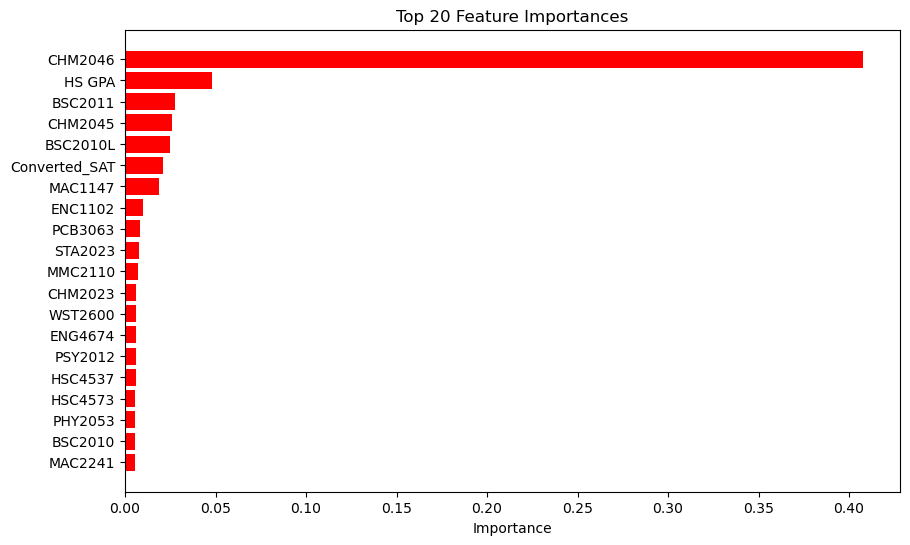

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the feature importances from the AdaBoost classifier
feature_importances = best_model.feature_importances_

# Get the column names (features)
feature_names = X.columns

# Pair the feature names with their corresponding importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Convert to a DataFrame for easy display and access
feature_importance_df = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

# Display the feature importances as a DataFrame
print("Feature Importances (sorted):")
print(feature_importance_df)

# Plotting the top 20 features for visualization
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
top_features = feature_importance_df.head(20)  # Plot the top 20 features
plt.barh(top_features['Feature'], top_features['Importance'], color='r')
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # To display the highest at the top
plt.show()

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

# X_train = X_undersampled
# y_train = y_undersampled
X_train = X
y_train = y
X_test = X_dev
y_test = y_dev
# X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=50)

model = AdaBoostClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],     # Number of boosting stages
    'learning_rate': [0.5, 1.0, 1.5]    # Learning rate
}

# Initialize GridSearchCV with the XGBoost classifier
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train the final model using the best parameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Label Model
print("############ AdaBoost Classifier ############")

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best Parameters: {'learning_rate': 0.5, 'n_estimators': 50}
Best Cross-Validation Accuracy: 0.88
############ AdaBoost Classifier ############
Accuracy: 0.87
Confusion Matrix:
[[   2  150]
 [   5 1021]]
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.01      0.03       152
           1       0.87      1.00      0.93      1026

    accuracy                           0.87      1178
   macro avg       0.58      0.50      0.48      1178
weighted avg       0.80      0.87      0.81      1178



Feature Importances (sorted):
       Feature  Importance
0      CHM2046        0.14
1     BSC2010L        0.06
2      BSC2011        0.06
3       HS GPA        0.06
4      BSC2010        0.04
...        ...         ...
1430  ZOO4307L        0.00
1431   ZOO4454        0.00
1432   ZOO4512        0.00
1433   ZOO4513        0.00
1434   ZOO4694        0.00

[1435 rows x 2 columns]


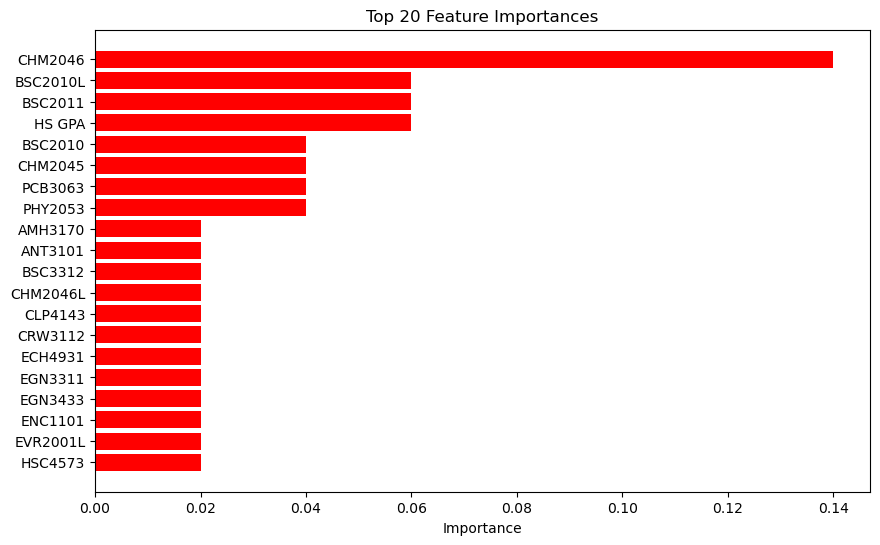

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the feature importances from the AdaBoost classifier
feature_importances = best_model.feature_importances_

# Get the column names (features)
feature_names = X.columns

# Pair the feature names with their corresponding importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Convert to a DataFrame for easy display and access
feature_importance_df = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

# Display the feature importances as a DataFrame
print("Feature Importances (sorted):")
print(feature_importance_df)

# Plotting the top 20 features for visualization
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
top_features = feature_importance_df.head(20)  # Plot the top 20 features
plt.barh(top_features['Feature'], top_features['Importance'], color='r')
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # To display the highest at the top
plt.show()

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# X_train = X_undersampled
# y_train = y_undersampled
X_train = X
y_train = y
X_test = X_dev
y_test = y_dev
# X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=50)

model = DecisionTreeClassifier(random_state=50)
param_grid = {
    'class_weight': [None, 'balanced'],    # Class weights
    'max_depth': [10],                     # Maximum depth of the tree
    'max_features': [None],                # Maximum number of features to consider when looking for the best split
    'min_samples_leaf': [4],               # Minimum number of samples required at a leaf node
    'min_samples_split': [10]              # Minimum number of samples required to split an internal node
}

# Initialize GridSearchCV with the XGBoost classifier
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train the final model using the best parameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Label Model
print("############ Decision Classifier ############")

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")



Best Parameters: {'class_weight': None, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Cross-Validation Accuracy: 0.86
############ Decision Classifier ############
Accuracy: 0.85
Confusion Matrix:
[[ 29 123]
 [ 57 969]]
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.19      0.24       152
           1       0.89      0.94      0.92      1026

    accuracy                           0.85      1178
   macro avg       0.61      0.57      0.58      1178
weighted avg       0.82      0.85      0.83      1178



Feature Importances (sorted):
            Feature  Importance
0           CHM2046    0.444355
1            HS GPA    0.057604
2           BSC2011    0.045227
3     Converted_SAT    0.035888
4           MAC1147    0.020002
...             ...         ...
1430       ZOO4307L    0.000000
1431        ZOO4454    0.000000
1432        ZOO4512    0.000000
1433        ZOO4513    0.000000
1434        ZOO4694    0.000000

[1435 rows x 2 columns]


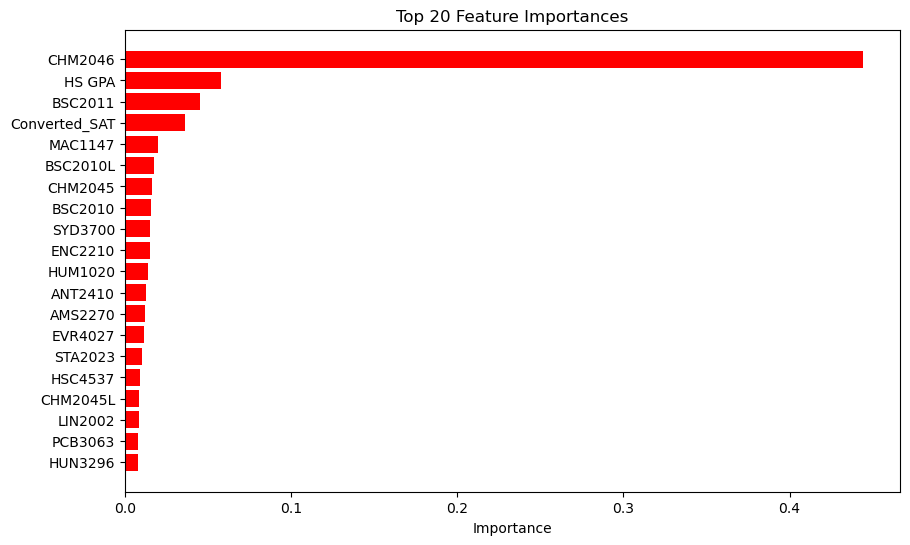

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the feature importances from the AdaBoost classifier
feature_importances = best_model.feature_importances_

# Get the column names (features)
feature_names = X.columns

# Pair the feature names with their corresponding importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Convert to a DataFrame for easy display and access
feature_importance_df = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

# Display the feature importances as a DataFrame
print("Feature Importances (sorted):")
print(feature_importance_df)

# Plotting the top 20 features for visualization
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
top_features = feature_importance_df.head(20)  # Plot the top 20 features
plt.barh(top_features['Feature'], top_features['Importance'], color='r')
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # To display the highest at the top
plt.show()

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# X_train = X_undersampled
# y_train = y_undersampled
X_train = X
y_train = y
X_test = X_dev
y_test = y_dev
# X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=50)

model = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 500],  # Number of trees
    'max_depth': [3, 5, 10, None],    # Depth of the trees
    'max_features': ['auto', 'sqrt'], # Number of features
    'bootstrap': [True, False]        # Sampling method
}

# Initialize GridSearchCV with the XGBoost classifier
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train the final model using the best parameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Label Model
print("############ Random Forest Classifier ############")

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
86 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\ProgramData\anaconda3\Lib\site-package

Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.88
############ Random Forest Classifier ############
Accuracy: 0.87
Confusion Matrix:
[[   4  148]
 [   6 1020]]
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.03      0.05       152
           1       0.87      0.99      0.93      1026

    accuracy                           0.87      1178
   macro avg       0.64      0.51      0.49      1178
weighted avg       0.81      0.87      0.82      1178



Feature Importances (sorted):
            Feature  Importance
0           CHM2046    0.062003
1            HS GPA    0.046634
2     Converted_SAT    0.041241
3           CHM2045    0.032767
4           MAC1147    0.022122
...             ...         ...
1430        THE2305    0.000000
1431        THE3110    0.000000
1432        TPP3155    0.000000
1433        TSL4362    0.000000
1434        TSL5085    0.000000

[1435 rows x 2 columns]


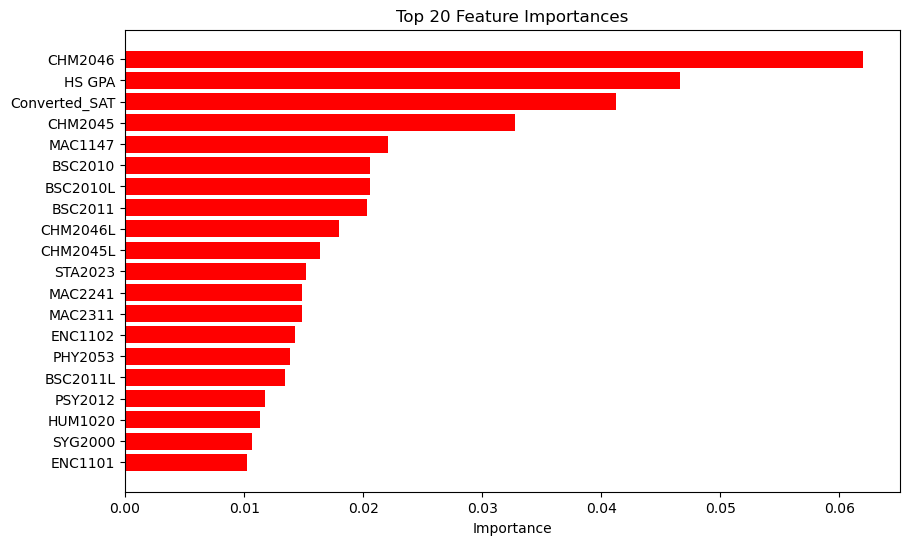

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the feature importances from the AdaBoost classifier
feature_importances = best_model.feature_importances_

# Get the column names (features)
feature_names = X.columns

# Pair the feature names with their corresponding importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Convert to a DataFrame for easy display and access
feature_importance_df = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

# Display the feature importances as a DataFrame
print("Feature Importances (sorted):")
print(feature_importance_df)

# Plotting the top 20 features for visualization
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
top_features = feature_importance_df.head(20)  # Plot the top 20 features
plt.barh(top_features['Feature'], top_features['Importance'], color='r')
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # To display the highest at the top
plt.show()

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# X_train = X_undersampled
# y_train = y_undersampled
X_train = X
y_train = y
X_test = X_dev
y_test = y_dev
# X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=50)

model = GaussianNB()
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7] # Variance smoothing parameter
}

# Initialize GridSearchCV with the XGBoost classifier
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train the final model using the best parameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Label Model
print("############ GaussianNB ############")

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")



Best Parameters: {'var_smoothing': 1e-07}
Best Cross-Validation Accuracy: 0.25
############ GaussianNB ############
Accuracy: 0.24
Confusion Matrix:
[[128  24]
 [869 157]]
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.84      0.22       152
           1       0.87      0.15      0.26      1026

    accuracy                           0.24      1178
   macro avg       0.50      0.50      0.24      1178
weighted avg       0.77      0.24      0.26      1178



In [19]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# # Get the feature importances from the AdaBoost classifier
# feature_importances = best_model.feature_importances_

# # Get the column names (features)
# feature_names = X.columns

# # Pair the feature names with their corresponding importances
# feature_importance_dict = dict(zip(feature_names, feature_importances))

# # Sort the features by importance in descending order
# sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# # Convert to a DataFrame for easy display and access
# feature_importance_df = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

# # Display the feature importances as a DataFrame
# print("Feature Importances (sorted):")
# print(feature_importance_df)

# # Plotting the top 20 features for visualization
# plt.figure(figsize=(10, 6))
# plt.title("Top 20 Feature Importances")
# top_features = feature_importance_df.head(20)  # Plot the top 20 features
# plt.barh(top_features['Feature'], top_features['Importance'], color='r')
# plt.xlabel("Importance")
# plt.gca().invert_yaxis()  # To display the highest at the top
# plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# X_train = X_undersampled
# y_train = y_undersampled
X_train = X
y_train = y
X_test = X_dev
y_test = y_dev
# X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=50)

model = LogisticRegression()
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['lbfgs', 'liblinear'],  # Solver choice
    'max_iter': [100, 200, 300]  # Number of iterations
}

# Initialize GridSearchCV with the XGBoost classifier
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train the final model using the best parameters
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Label Model
print("############ Logistic Regression ############")

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")



Best Parameters: {'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 0.88
############ Logistic Regression ############
Accuracy: 0.87
Confusion Matrix:
[[   3  149]
 [   8 1018]]
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.02      0.04       152
           1       0.87      0.99      0.93      1026

    accuracy                           0.87      1178
   macro avg       0.57      0.51      0.48      1178
weighted avg       0.79      0.87      0.81      1178



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the feature importances from the AdaBoost classifier
feature_importances = best_model.feature_importances_

# Get the column names (features)
feature_names = X.columns

# Pair the feature names with their corresponding importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Convert to a DataFrame for easy display and access
feature_importance_df = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

# Display the feature importances as a DataFrame
print("Feature Importances (sorted):")
print(feature_importance_df)

# Plotting the top 20 features for visualization
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
top_features = feature_importance_df.head(20)  # Plot the top 20 features
plt.barh(top_features['Feature'], top_features['Importance'], color='r')
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # To display the highest at the top
plt.show()

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'